# Where should we place the tech teams? 

### Using the latitude and longitude, and the distance between each location, determine the 5 best locations for a team to be placed so that they minimize the drive time to any of their locations while balancing the number of loads between the teams. 

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pyodbc
import os
np.random.seed(0)
%matplotlib inline

In [2]:
# Make sure environment variables are available for connection string
print(os.environ.get('SQL_SERVER'))
print(os.environ.get('SQL_DATABASE'))

MINI-DESKTOP
HCS


In [3]:
# Create connection string using environment variables. 
# This is setup for windows authentication on SQL Server. 
# Conn is the connection to pyodbc
connection_string = 'DRIVER={SQL Server};SERVER=' + os.environ['SQL_SERVER'] + ';DATABASE=' + os.environ['SQL_DATABASE'] + ';Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

In [4]:
# Create a cursor to execute SQL queries against the database
cursor = conn.cursor()

In [5]:
# Create a query to feed into the program 
query = "SELECT School_Name, SchoolType, Latitude, Longitude FROM SchoolInfo;  "

In [6]:
# Execute the query
# retrieve the rows and iterate over them

cursor.execute(query)
rows = cursor.fetchall()
rows = [tuple(np.nan if val is None else val for val in row) for row in rows] #Handle nulls



In [7]:
# Feed the table into the dataframe
df = pd.DataFrame(rows, columns=[column[0] for column in cursor.description])


In [8]:
#Look at the data
df.head()

,School_Name,SchoolType,Latitude,Longitude
0,Allen Elementary,E,35.237514,-85.151484
1,Alpine Crest Elem,E,35.130010,-85.271737
2,Apison Elementary School,E,34.998403,-85.057853
3,Barger Academy,E,35.012788,-85.229972
4,Battle Academy,E,35.036108,-85.307855


In [9]:
#Split the data into labels and numerics
X = df[['Latitude','Longitude']]
y = df['School_Name']

In [10]:
#Look at the numerics
X.head()

,Latitude,Longitude
0,35.237514,-85.151484
1,35.130010,-85.271737
2,34.998403,-85.057853
3,35.012788,-85.229972
4,35.036108,-85.307855


## Perform K-Means function on data to find K centers in the data

In [11]:
# Build the k-means function
def k_means(X,K): 
    # Keep track of history so you can see K-Means in action 
    centroids_history = []
    labels_history = []
    rand_index = np.random.choice(X.shape[0], K)
    centroids = X[rand_index]
    centroids_history.append(centroids)
    while True: 
        # Euclidean distance calculated for each point relative to centroids, then np.argmin returns 
        # index location of min distance = which cluster a point is assigned to
        labels = np.argmin(cdist(X,centroids), axis=1)
        unique_labels, counts = np.unique(labels, return_counts=True)
        
        empty_clusters = unique_labels[counts == 0]
        for empty_cluster in empty_clusters:
            # If a cluster is empty, choose a random point as the centroid
            centroids[empty_cluster] = X[np.random.choice(X.shape[0])]
            
        labels_history.append(labels)
        # Take mean of points within clusters to find new centroids
        new_centroids = np.array([X[labels == i].mean(axis=0)
                                  if np.sum(labels == i) > 0
                                  else np.full(X.shape[1], np.nan)  # Use np.full to create an array of NaNs
                                  for i in range(K)])
        
        centroids_history.append(new_centroids)
        
        # If old centroids and new centroids no longer change, K-Means is complete and ends. Otherwise, continue
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, labels, centroids_history, labels_history

In [12]:
# convert pandas dataframe into a numpy matrix
X_mat = X.values

In [14]:
# Run matrix through the k_means function
centroids, labels, centroids_history, labels_history = k_means(X_mat, 5)

## Save the data back to the dataframe

In [15]:
# Assign a new Cluster column to the dataframe with the labels at the end
df['Cluster'] = labels

## Illustrate the process using matplotlib

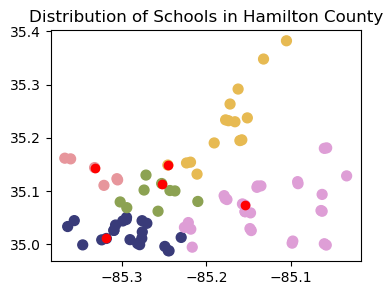

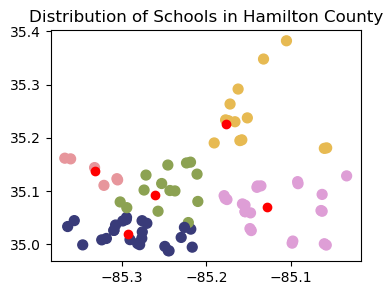

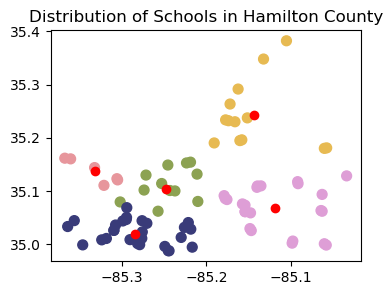

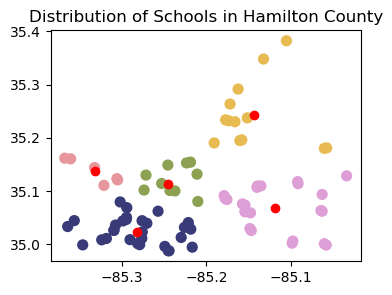

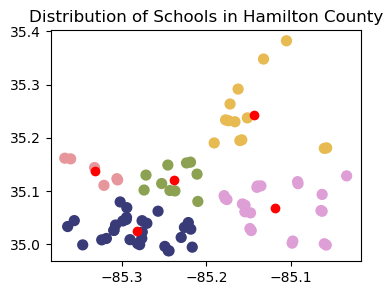

In [18]:
#Illustrate how the kmeans algo finds 5 center points. 

history = zip(centroids_history,labels_history)
for x,y in history: 
    plt.figure(figsize=(4,3))
    scatter = plt.scatter( X['Longitude'],X['Latitude'], c = y, s=50, cmap='tab20b')
    plt.scatter( x[:,1],x[:,0], c='red')
    plt.title('Distribution of Schools in Hamilton County')
    #plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()

# Use Driving Distance as opposed to Euclidean Distance